# Predicting Income using US Census Data
In this lab we will be using part of the [adult dataset](https://archive.ics.uci.edu/ml/datasets/adult) which is a 1994 US census dataset to predict whether a given person has an income greater than $50k a year.

## Imports
* **Pandas** is a common data science package allowing for efficient storage of data (see [dataframes](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html))
* **Matplotlib** is used for plotting data
* **Numpy** is an efficient array framework
* **Pytorch** library is a ML library made by Meta
* **aif360.sklearn** is used to download the adult dataset

In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
!pip install 'aif360'
from aif360.sklearn.datasets import fetch_adult
from sklearn.model_selection import train_test_split

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Data Setup
We collect the adult dataset using `fetch_adult()` (downloads as **Pandas** *Dataframes*) and break it into **X** (parameters) and **y** (actual income). We fetch twice once to get the data for viewing (ie: Strings rather than numerical data) and the other as numerical data for plugging into our model. We can use `display()` to display these *dataframes*.

In [120]:
# For viewing
adult_view = fetch_adult()
adult_parameters_view = adult_view.X
adult_income_view = adult_view.y

## Filtering view data to match numerical data
columns = ["age", "education", "race","sex", "capital-gain", "capital-loss",	"hours-per-week"]
adult_parameters_view = adult_parameters_view.filter(items=columns)

# For use in model
adult = fetch_adult(numeric_only=True)
adult_parameters = adult.X
adult_income = adult.y

In [121]:
display(adult_parameters_view)

age     education   race     sex  capital-gain  \
race      sex                                                       
Non-white Male    25.0          11th  Black    Male           0.0   
White     Male    38.0       HS-grad  White    Male           0.0   
          Male    28.0    Assoc-acdm  White    Male           0.0   
Non-white Male    44.0  Some-college  Black    Male        7688.0   
White     Male    34.0          10th  White    Male           0.0   
...                ...           ...    ...     ...           ...   
          Female  27.0    Assoc-acdm  White  Female           0.0   
          Male    40.0       HS-grad  White    Male           0.0   
          Female  58.0       HS-grad  White  Female           0.0   
          Male    22.0       HS-grad  White    Male           0.0   
          Female  52.0       HS-grad  White  Female       15024.0   

                  capital-loss  hours-per-week  
race      sex                                   
Non-white Male             0.0            40.0  
White     Male             0.0            50.0  
          Male             0.0            40.0  
Non-white Male             0.0            40.0  
White     Male             0.0            30.0  
...                        ...             ...  
          Female           0.0            38.0  
          Male             0.0            40.0  
          Female           0.0            40.0  
          Male             0.0            20.0  
          Female           0.0            40.0  

[45222 rows x 7 columns]

In [122]:
display(adult_parameters)

age  education-num  race  sex  capital-gain  capital-loss  \
race sex                                                               
0    1    25.0            7.0     0    1           0.0           0.0   
1    1    38.0            9.0     1    1           0.0           0.0   
     1    28.0           12.0     1    1           0.0           0.0   
0    1    44.0           10.0     0    1        7688.0           0.0   
1    0    18.0           10.0     1    0           0.0           0.0   
...        ...            ...   ...  ...           ...           ...   
     0    27.0           12.0     1    0           0.0           0.0   
     1    40.0            9.0     1    1           0.0           0.0   
     0    58.0            9.0     1    0           0.0           0.0   
     1    22.0            9.0     1    1           0.0           0.0   
     0    52.0            9.0     1    0       15024.0           0.0   

          hours-per-week  
race sex                  
0    1              40.0  
1    1              50.0  
     1              40.0  
0    1              40.0  
1    0              30.0  
...                  ...  
     0              38.0  
     1              40.0  
     0              40.0  
     1              20.0  
     0              40.0  

[48842 rows x 7 columns]

## Cleaning up data
Here we prepare our data for our predictive model. To do so we need to convert our *dataframes* to **Pytorch** *tensors*. Additionally we will need to cast them as floats (all data needs to be of same type).

In [123]:
parameters = torch.tensor(adult_parameters.values)
parameters = parameters.to(torch.float32)

income = torch.tensor(adult_income.values)
income = income.to(torch.float32)

# This last step is simply to get the dimensions of income to be the same as parameters
income = income[:, None]

## Splitting Testing and Training Data
We lastly want to break up our data into training and testing data. However, if we just split the data without any preprocessing we'll get a biased model. This is because the vast majority of the people in the dataset make less than the $50k threshold, resulting in our model learning to always predict less than 50k. Try commenting out the preprocessing and seeing it for yourself. 

In [124]:
# Train test split
train_X, test_X, train_y, test_y = train_test_split(parameters, income, test_size=0.33, random_state=42)

In [125]:
# Preprocessing
indicies_zero = (train_y == 0).nonzero().numpy() # index of all people making <50k
indicies_nonzero = train_y.nonzero().numpy() # index of all people making >50k
ones = len(indicies_nonzero) # number of people making >50k

# creates a combined list of index of people making >50k and equal number of people making <50k
combined_indicies = np.concatenate((indicies_nonzero[:,0],indicies_zero[:ones,0]), axis=0) 
combined_indicies = np.sort(combined_indicies)

# filtering training data so there are equal number of >50k and <50k data points
train_X = torch.index_select(train_X, 0, torch.from_numpy(combined_indicies))
train_y = torch.index_select(train_y, 0, torch.from_numpy(combined_indicies))

# Neural Network
Now we can begin to build our Neural Network model!
To build a basic neural network we want to start with [`nn.Sequential()`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential). This will tell Pytorch we are building a Neural Network with select layers in the specified order. We can add which **layers**/**activation functions** we want to use inside `nn.Sequential()`.

This should look something like:
```
model = nn.Sequential(
  Layer1,
  Activation_Function1,
  Layer2,
  Activation_Function2,
  ...
  )
```
There are many different **Layers** you can use but the one covered in the presentation is [`nn.Linear()`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear). This simple layer takes in 2 parameters: the number of input neurons and number of output neurons. Start off with using `nn.Linear()`, but also try other layers found [here](https://pytorch.org/docs/stable/nn.html) such as convolution or pooling layers. 

**Activation Functions** like [`nn.ReLU()`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) and [`nn.Sigmoid()`](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html#torch.nn.Sigmoid) are very common but you can find the whole list [here](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) and [here](https://pytorch.org/docs/stable/nn.html#non-linear-activations-other)

Don't be afraid to try out new things even if you don't fully understand them. The best way to learn is to get hands on experience!

In [126]:
model = nn.Sequential(
    nn.Linear(len(adult_parameters.columns), 10),
    nn.ReLU(),
    nn.BatchNorm1d(10),
    nn.Linear(10,8),
    nn.ReLU(),
    nn.BatchNorm1d(8),
    nn.Linear(8,1),
    nn.ReLU(),
)
print(model)

Sequential(
  (0): Linear(in_features=7, out_features=10, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=10, out_features=8, bias=True)
  (4): ReLU()
  (5): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=8, out_features=1, bias=True)
  (7): ReLU()
)


## Loss Function and Optimizer
Here we want to define what our **loss function** is. Here we would suggest using [`nn.MSELoss()`](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss) which is the mean squared loss. Using MSE will define loss as the average of the difference between predicted and actual output squared.
$\frac{1}{n}$ $\sum_{i=1}^{n} (actual-predicted)^2$ You can find other loss functions [here](https://pytorch.org/docs/stable/nn.html#loss-functions)

**Optimizers** are the algorithms used to train or optimize weights and biases. Different algorithms have different strengths and weaknesses but the most understandable would be [`torch.optim.SGD()`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD). SGD or Stochastic Gradient Descent is the method that uses the derivative/slope (gradient) to identify how to modify each weight to decrease loss. SGD takes [`model.parameters()`](https://pytorch.org/docs/stable/optim.html#algorithms) and learning rate (decimal typically between `0.1` and `0.001`) as parameters.

![Gradient Descent](https://egallic.fr/Enseignement/ML/ECB/book/figs/example_two_dim/descent_2D_sphere.gif)

You can find other Optimizers [here](https://pytorch.org/docs/stable/optim.html#algorithms)

In [127]:
loss_function = nn.MSELoss()
learning_rate = 0.003
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## Training
We can now start training our Neural Network and optimizing for the best weights/biases. In addition to training our model we also want to be able to view how our model performs, so we will also **save our loss at each epoch** to plot later. 

To begin we must **loop** through a set of training steps; each set of steps is known as an epoch. The more epochs we train with the more optimized our NN will become, however after a certain number of epochs that rate decreases and becomes insubstantial.

Within each epoch we must do 5 things:
1. **Run the model** on our Training input data to get the models prediction:
  `model(data)` will *return the predictions* for each input as a tensor (specialized array).
2. **Calculate the loss** using the loss function defined previously. Using the *predicted values* and *actual values* as parameters for the loss function will *return the loss*
3. **Reset the gradient** with `model.zero_grad()`. The gradient is used to optimize the weights and if we don't reset it, then the gradient will accumulate with each epoch
4. **Backward propagation** will calculate the gradient from the loss from step 2. Calling `loss.backward()` will automatically store the model's gradient to be used in the next step
5. **Stepping the weights** will update the weights with the gradient calculated through backward propagation. To do so simply call `optimizer.step()` with the optimizer defined in the previous cell

View documentation [here](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#the-training-loop)

In [128]:
losses = []
epochs = 100
for epoch in range(epochs):
  y_pred = model(train_X)
  loss = loss_function(y_pred, train_y)
  losses.append(loss.item())
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

## Plotting Loss over Epochs

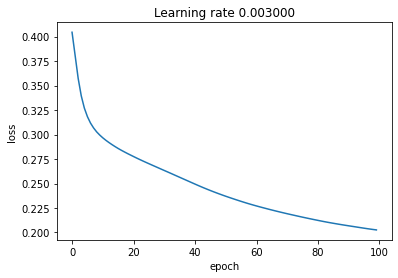

In [129]:
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("Learning rate %f"%(learning_rate))
plt.show()

# Testing and Running the Neural Network
The final step is to **test and run** the trained neural network. We can now run the neural network the same way as we trained it to get the predicted values for the test data (rather than using training data). To evaluate our model, we can use the same loss function to find our final loss. 

In [130]:
pred_y = model(test_X)
loss = loss_function(pred_y, test_y)
print(loss.item())

accuracy = 0
for i in range(len(pred_y)):
    if pred_y[i] > 0.5:
        pred_y[i] = 1
    else:
        pred_y[i] = 0
    if pred_y[i] == test_y[i]:
        accuracy += 1
accuracy = accuracy/len(pred_y)

print(str(round(accuracy*100,2)) + '%')


0.15787270665168762
78.04%


## Displaying the predictions with the parameters

In [131]:
compiled_results = test_X.detach().numpy()
compiled_results = np.append(compiled_results, test_y.detach().numpy(), axis=1)
compiled_results = np.append(compiled_results, pred_y.detach().numpy(), axis=1)
compiled_results = np.append(compiled_results, np.rint(pred_y.detach().numpy()), axis=1)
compiled_results = pd.DataFrame(compiled_results, columns=["age", "education-num", "race",	"sex", "capital-gain", "capital-loss",	"hours-per-week", "actual_income", "predicted_income", "rounded_prediction"])
display(compiled_results)

,age,education-num,race,sex,capital-gain,capital-loss,hours-per-week,actual_income,predicted_income,rounded_prediction
0,56.0,9.0,1.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0
1,25.0,9.0,0.0,1.0,0.0,0.0,40.0,0.0,0.0,0.0
2,43.0,13.0,1.0,0.0,14344.0,0.0,40.0,1.0,1.0,1.0
3,32.0,9.0,1.0,1.0,0.0,0.0,40.0,0.0,0.0,0.0
4,39.0,13.0,1.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
16113,50.0,9.0,1.0,1.0,0.0,0.0,40.0,0.0,0.0,0.0
16114,34.0,7.0,1.0,0.0,0.0,0.0,70.0,0.0,1.0,1.0
16115,59.0,9.0,1.0,1.0,0.0,0.0,45.0,1.0,0.0,0.0
16116,22.0,12.0,1.0,0.0,0.0,0.0,35.0,0.0,0.0,0.0


# Congrats!
You just finished training and running your first (or not your first) Neural Network. Now go back and start tweeking different settings and play around using different layers, activation functions, optimizers, and more.

### Challenge
If you finish early, go look at the results and see if you notice any patterns. Can you identify false positives or true negative? How may this cause issues? Now see what you can do to either A. decrease overall loss and B. decrease false positive/true negatives. The optimization of both A and B is the center of Responsible Artificial Intelligence (and the existance of protected classes/anti-discriminatory practices...)